In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
import seaborn as sns

For starters, only load 500 malicious and benign data sets (each)

In [3]:
READ_LINES = 500
malicious_data = pd.read_csv('/rodata/exercise03/clam_mal.csv', index_col=None, nrows=READ_LINES)
benign_data = pd.read_csv('/rodata/exercise03/clam_benign.csv', index_col=None, nrows=READ_LINES)

Merge malicious and clean data (features), remove sample hashes, and split out classes

In [4]:
learn_data = malicious_data.append(benign_data, ignore_index=True)
learn_data.fillna(0, inplace=True) # fill missing entries from either set with 0
raw_data = learn_data.copy()
classes = learn_data['malicious']
del learn_data['malicious']
del learn_data['hash']

/tmp/ipykernel_88819/242214423.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learn_data = malicious_data.append(benign_data, ignore_index=True)


##### remove data with just one value

In [15]:
count = 0
for (columnName, columnData) in learn_data.iteritems():
    if len(np.unique(columnData.values)) == 1:
        del learn_data[columnName]
        count = count +1
print('Number of features removed: {}'.format(count)) 

Number of features removed: 10597


Let's split out 20% for testing

In [16]:
features_train, features_test, classes_train, classes_test = \
model_selection.train_test_split(learn_data, classes, test_size=0.2, random_state=0)

We will use a Random Forest (multiple Decision Trees combined) and train on the TRAIN set

In [17]:
classifier = ensemble.RandomForestClassifier()
classifier.fit(features_train, classes_train)

RandomForestClassifier()

The split into TRAIN and TEST sets simulates working with unknown data

Q: How good is the result with this train/test split?

Q: Does the result change when running with different "splits"?

In [18]:
prediction = classifier.predict(features_test)
print(metrics.recall_score(classes_test, prediction))
print(metrics.confusion_matrix(classes_test, prediction))

0.826530612244898
[[86 16]
 [17 81]]


Repeating this manually is tedious. Let's automate this using
# N-fold Cross-Validation #
Repeat experiment N times, each time keeping 1/N-th of TEST data. As input, we provide the full data set.

We will use N=5 (paramater "cv"), which runs 5 times with 20% as TEST data each.

In [19]:
classifier = ensemble.RandomForestClassifier()
scores = model_selection.cross_val_score(classifier, learn_data,
                                         classes, cv = 5, scoring='recall')
print(scores)

[0.82 0.83 0.87 0.79 0.87]


Let's get some statistical numbers for the accuracy (mean, standard deviation)

In [20]:
#print("Accuracy: %.3f (+/- %.3f)" % (scores.mean(), scores.std() * 2))
print("Recall: %.3f (+/- %.3f)" % (scores.mean(), scores.std() * 2))

Recall: 0.836 (+/- 0.061)


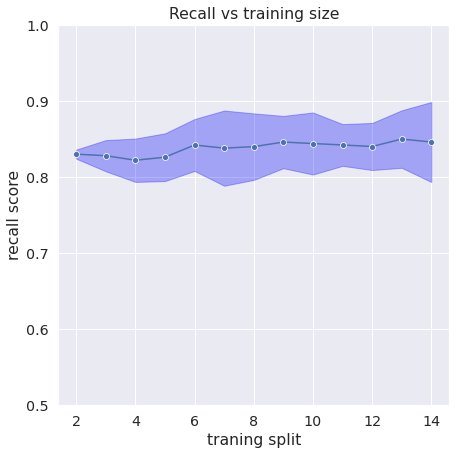

In [38]:
cvs = np.arange(2,15,1)
scores_array = []
scores_std_array = []
for i in cvs:
    scores = model_selection.cross_val_score(classifier, learn_data,
                                         classes, cv = i, scoring='recall')
    scores_array.append(scores.mean())
    scores_std_array.append(scores.std())

sa = np.array( scores_array) 
sa_std = np.array( scores_std_array) 
fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
ax = sns.lineplot(x =cvs, y= sa, marker='o')

# Plot accurancy bands for training and test sets
ax.fill_between(cvs, sa - sa_std,
                 sa + sa_std, color="blue",  alpha=0.3)

ax.set_title('Recall vs training size')
ax.set_xlabel('traning split')
ax.set_ylabel('recall score')
ax.set_ylim(0.5,1)
plt.show()

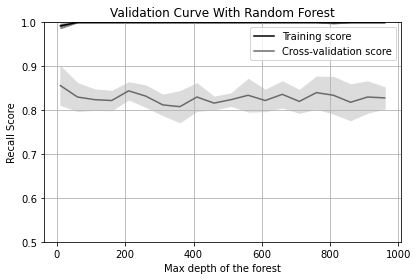

In [27]:
# Try hyperparameters on the dataset: max depth
param_range = np.arange(10, 1000, 50)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    classifier,
    # Feature matrix
    learn_data,
    # Target vector
    classes,
    # Hyperparameter to examine
    param_name="max_depth",
    # Range of hyperparameter's values
    param_range=param_range,
    # Number of folds
    cv=3,
    # Performance metric
    scoring="recall",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max depth of the forest")
plt.ylabel("Recall Score")
plt.tight_layout()
plt.legend(loc="best")
plt.ylim(.50,1)
plt.grid()
plt.show()